# Single-Cell RNA-seq Filtering and Normalization

A step-by-step processing pipeline for single-cell RNA-seq data:
- QC filtering
- Normalization and log transformation
- Doublet detection
- Cell cycle scoring and regression
- Dimensionality reduction, clustering, UMAP visualization
- Marker gene identification

In [11]:
!pip install scanpy scrublet matplotlib pandas igraph leidenalg
!pip install --upgrade --force-reinstall umap-learn torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00


In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
import umap

# Scanpy settings for better outputs
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, facecolor='white')

## Generate Synthetic Data with Mitochondrial and Cell Cycle Genes

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd

np.random.seed(42)
n_cells = 1000
n_genes = 500

# Base counts - Poisson distributed UMI counts
X = np.random.poisson(lam=1.5, size=(n_cells, n_genes))

# Add 20 mitochondrial genes (MT-) with elevated counts in some cells
mt_gene_indices = np.random.choice(range(n_genes), size=20, replace=False)
for i in mt_gene_indices:
    X[:, i] += np.random.binomial(n=5, p=0.1, size=n_cells)

# Add cell cycle genes
s_genes = [
    "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4",
    "RRM1", "UNG", "GINS2", "MCM6", "CDCA7", "DTL",
    "PRIM1", "UHRF1", "MCM10", "TIPIN", "NASP", "RAD51AP1",
    "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3",
    "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6",
    "EXO1", "TIPIN", "POLA1", "CHAF1B", "BRIP1", "E2F8"
]

g2m_genes = [
    "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2",
    "TOP2A", "NDC80", "CKS2", "NUF2", "CKS1B", "MKI67",
    "TMPO", "CENPF", "TACC3", "FAM64A", "SMC4", "CCNB2",
    "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E",
    "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "CDC20",
    "TTK", "CDC25C", "KIF2C"
]

# Check length and overlap with existing gene count
total_ccgs = s_genes + g2m_genes
n_ccgs = len(total_ccgs)

# Generate base expression for cell cycle genes with variation across cells
def simulate_ccg_expression(n_cells, n_ccgs):
    base_expr = np.abs(np.random.normal(loc=3, scale=1, size=(n_cells, n_ccgs)))
    noise = np.random.poisson(1, size=(n_cells, n_ccgs))
    expr = base_expr + noise
    return expr.astype(int)

ccg_expr = simulate_ccg_expression(n_cells, n_ccgs)

# Combine base expression + mitochondrial genes + cell cycle genes
# We keep initial 480 non-MT genes + 20 MT genes + cell cycle genes appended at the end
gene_names_base = [f"gene_{i}" for i in range(1, n_genes - 20 + 1)]
mt_genes = [f"MT-{i}" for i in range(1, 21)]
all_genes = gene_names_base + mt_genes + total_ccgs

# Expand X to have space for cell cycle genes
X_expanded = np.zeros((n_cells, len(all_genes)), dtype=int)

# Copy base genes
X_expanded[:, :480] = X[:, :480]
# Copy MT genes
X_expanded[:, 480:500] = X[:, 480:500]
# Copy cell cycle genes
X_expanded[:, 500:] = ccg_expr

# Create AnnData object
adata = sc.AnnData(X_expanded)
adata.var_names = all_genes
adata.var['mt'] = adata.var_names.str.startswith("MT-")
adata.obs['batch'] = np.random.choice(['batch1', 'batch2'], size=n_cells)

# adata
# adata.var
# adata.obs


# sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

## Quality Control and Filtering

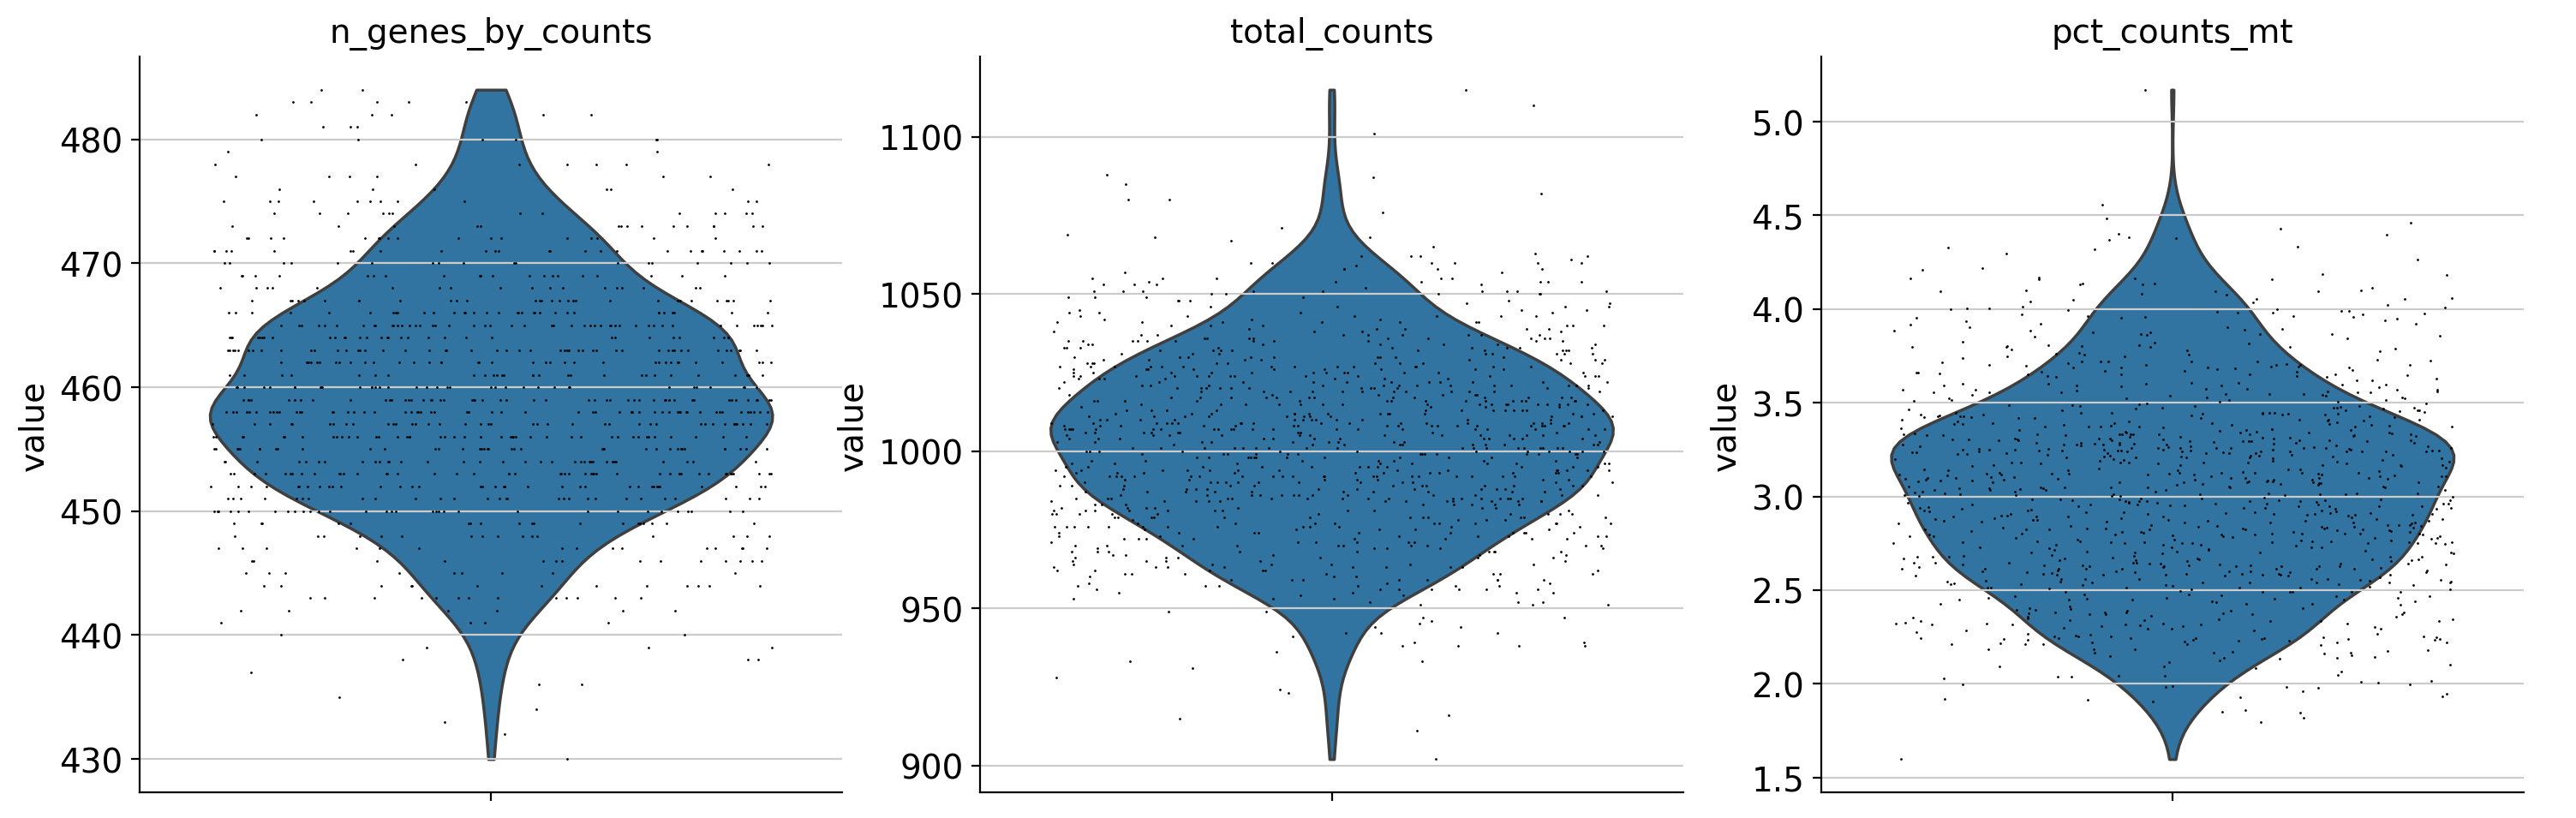

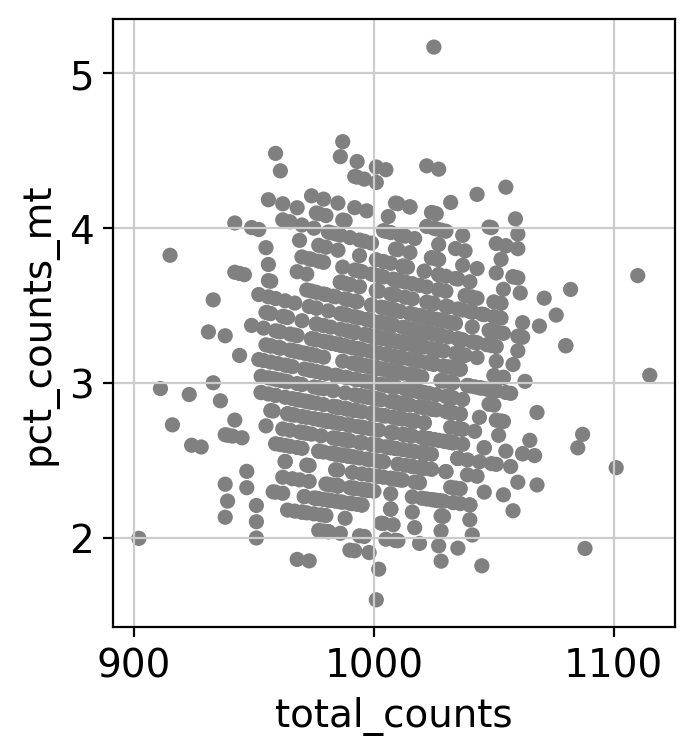

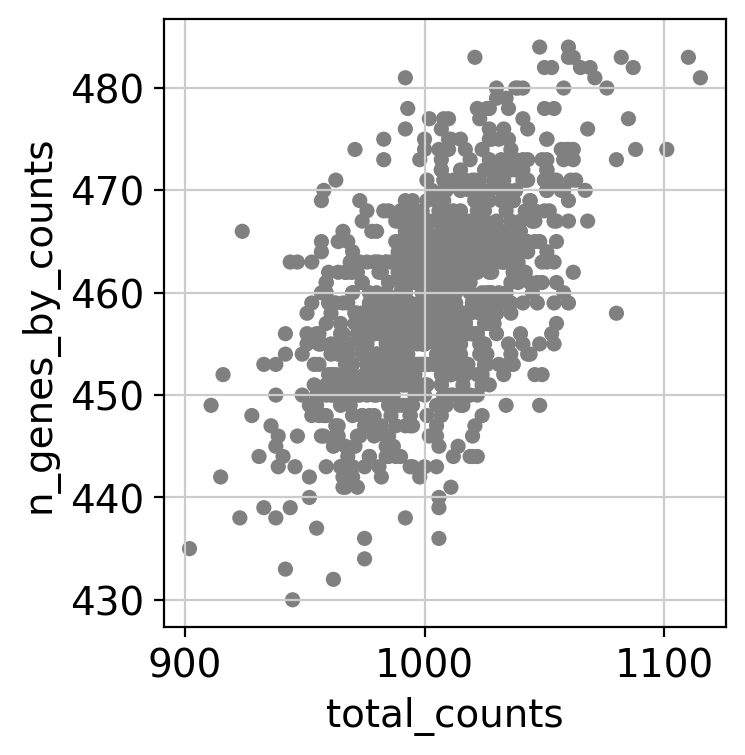

In [3]:
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [4]:
filtered_adata = adata[(adata.obs['n_genes_by_counts'] >= 200) & (adata.obs['pct_counts_mt'] <= 15)].copy()
print(f"Cells before filtering: {adata.n_obs}")
print(f"Cells after filtering: {filtered_adata.n_obs}")

Cells before filtering: 1000
Cells after filtering: 1000


## Doublet Detection with Scrublet

In [5]:
# Run Scrublet doublet detection on raw filtered counts
scrub = scr.Scrublet(filtered_adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
filtered_adata.obs['doublet_score'] = doublet_scores
filtered_adata.obs['predicted_doublet'] = predicted_doublets

filtered_adata.obs['predicted_doublet'].value_counts()

# Filter out predicted doublets
filtered_adata = filtered_adata[~filtered_adata.obs['predicted_doublet']].copy()

filtered_adata

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 28.1%
Estimated detectable doublet fraction = 42.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 66.8%
Elapsed time: 0.8 seconds


AnnData object with n_obs × n_vars = 719 × 569
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization and Log Transformation

In [6]:
sc.pp.normalize_total(filtered_adata, target_sum=1e4)
sc.pp.log1p(filtered_adata)
# sc.pp.regress_out(filtered_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(filtered_adata)

normalizing counts per cell
    finished (0:00:00)


## Cell Cycle Scoring and Regression

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    350 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    280 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


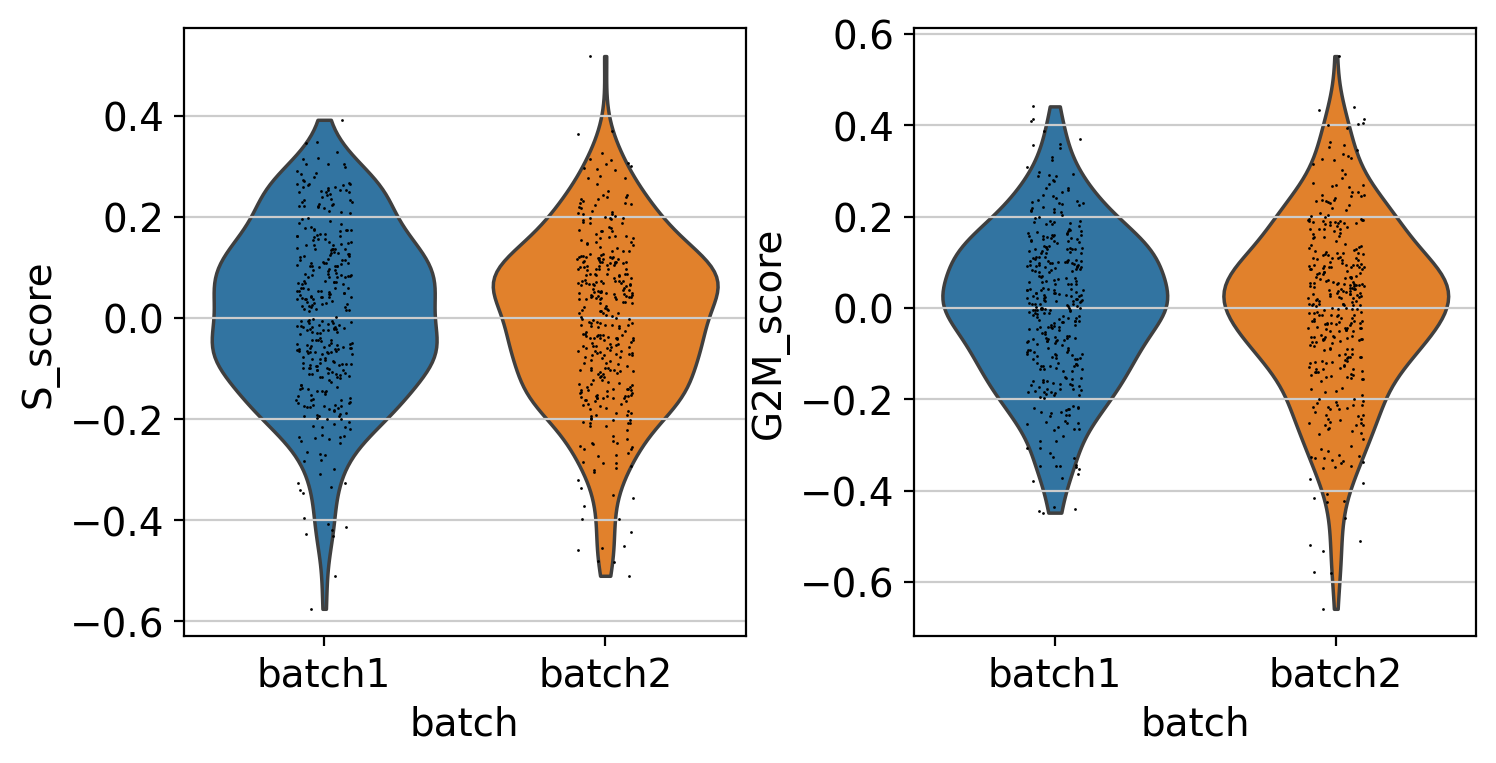

regressing out ['S_score', 'G2M_score']


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


    finished (0:00:08)


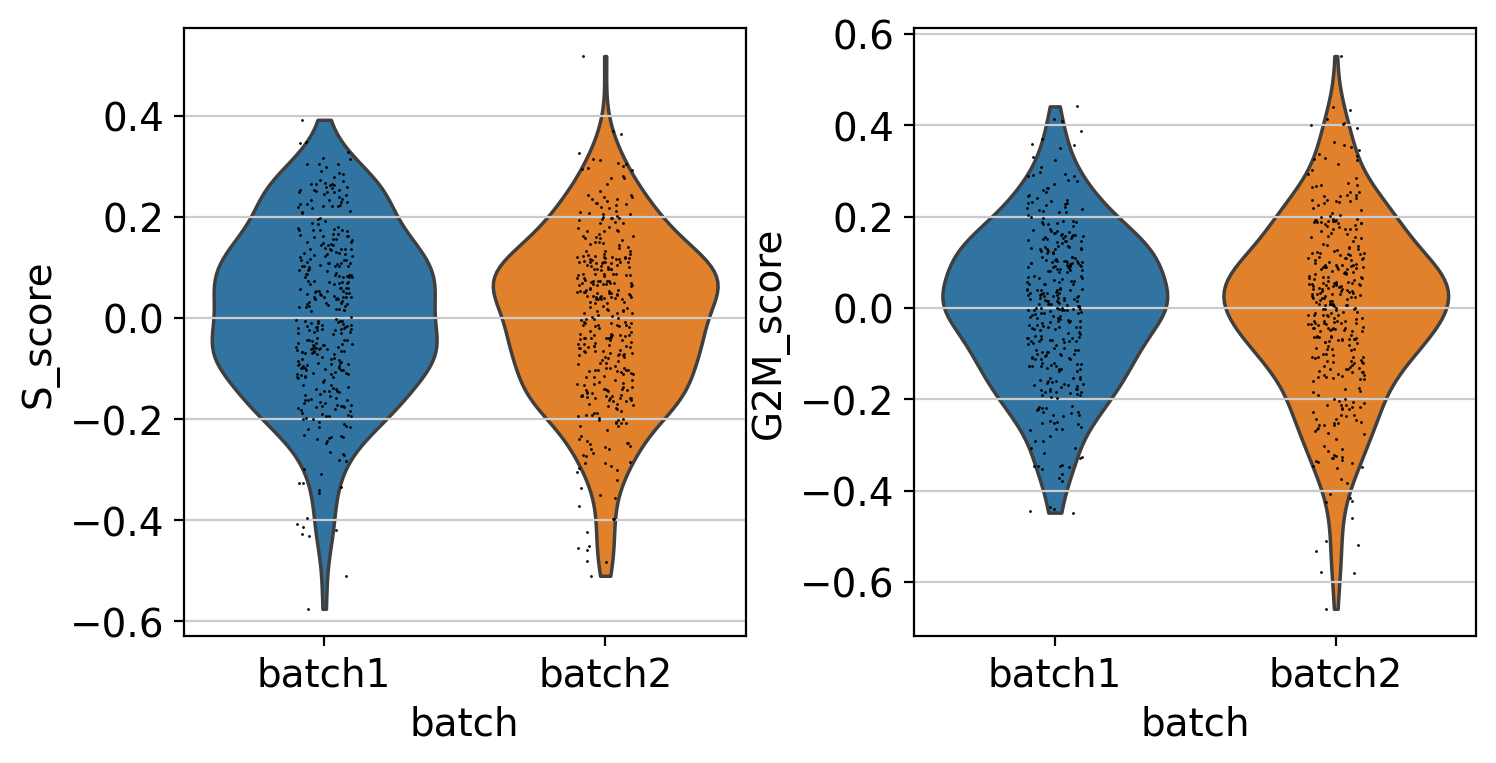

In [7]:
# s_genes = sc.queries.cell_cycle_genes.s_genes
# g2m_genes = sc.queries.cell_cycle_genes.g2m_genes
sc.tl.score_genes_cell_cycle(filtered_adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pl.violin(filtered_adata, ['S_score', 'G2M_score'], groupby='batch')
sc.pp.regress_out(filtered_adata, ['S_score', 'G2M_score'])
sc.pp.scale(filtered_adata)
sc.pl.violin(filtered_adata, ['S_score', 'G2M_score'], groupby='batch')

## Dimensionality Reduction, Clustering, and Visualization

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)
running Leiden clustering


/tmp/ipython-input-1226355025.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(filtered_adata, resolution=0.5)


    finished: found 1 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


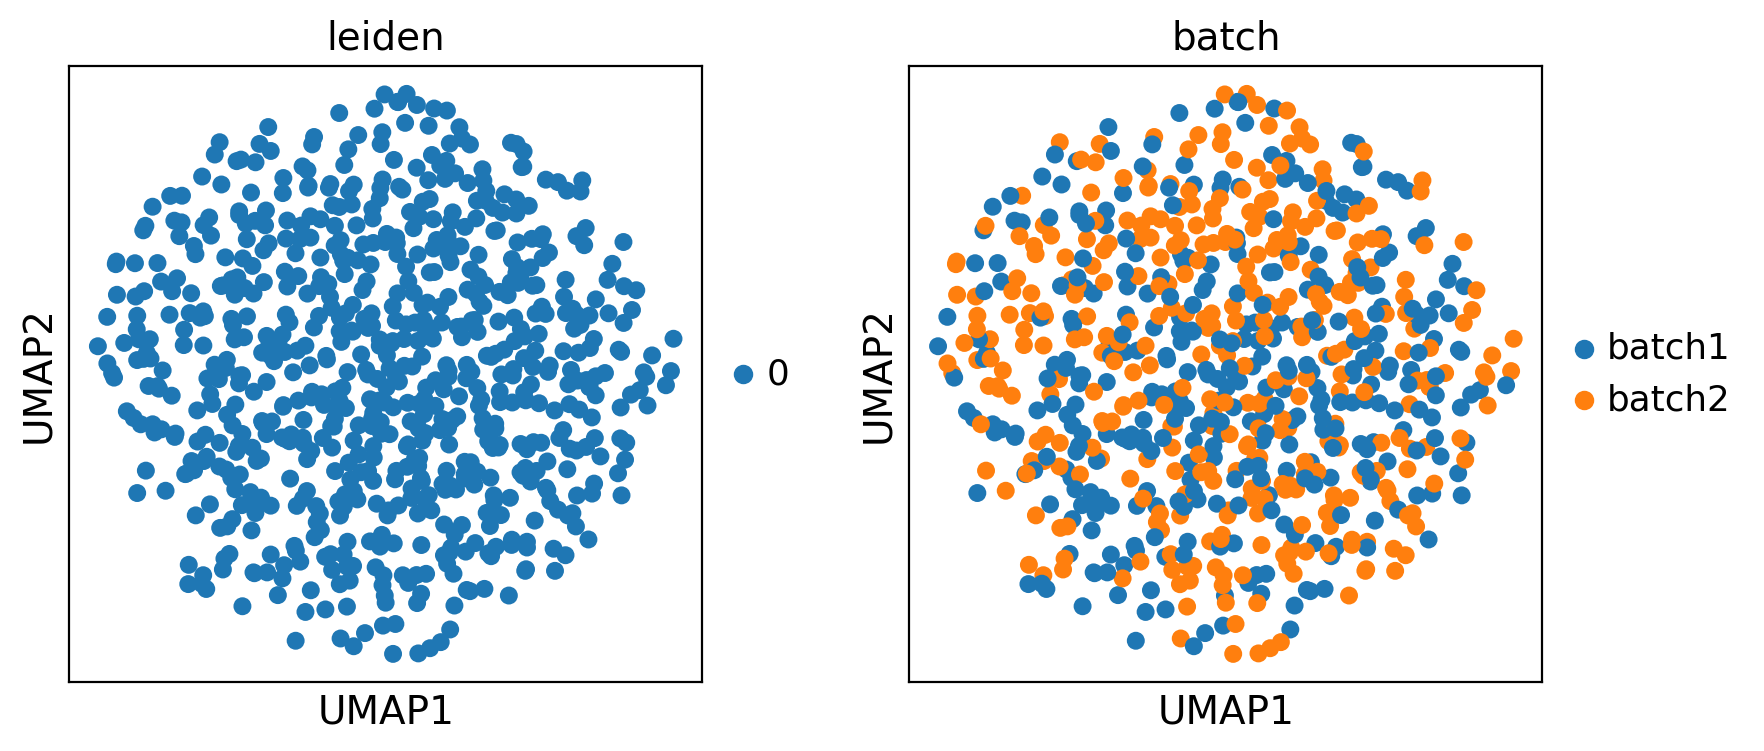

In [12]:
sc.tl.pca(filtered_adata, svd_solver='arpack')
sc.pp.neighbors(filtered_adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(filtered_adata)
sc.tl.leiden(filtered_adata, resolution=0.5)
sc.pl.umap(filtered_adata, color=['leiden', 'batch'])

## Marker Gene Identification

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_utils.py:31: RuntimeWarning: Mean of empty slice.
  return X.mean(axis=axis, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:378: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_tools/__init__.py:459: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[-1].set_ylim(ymin, ymax)


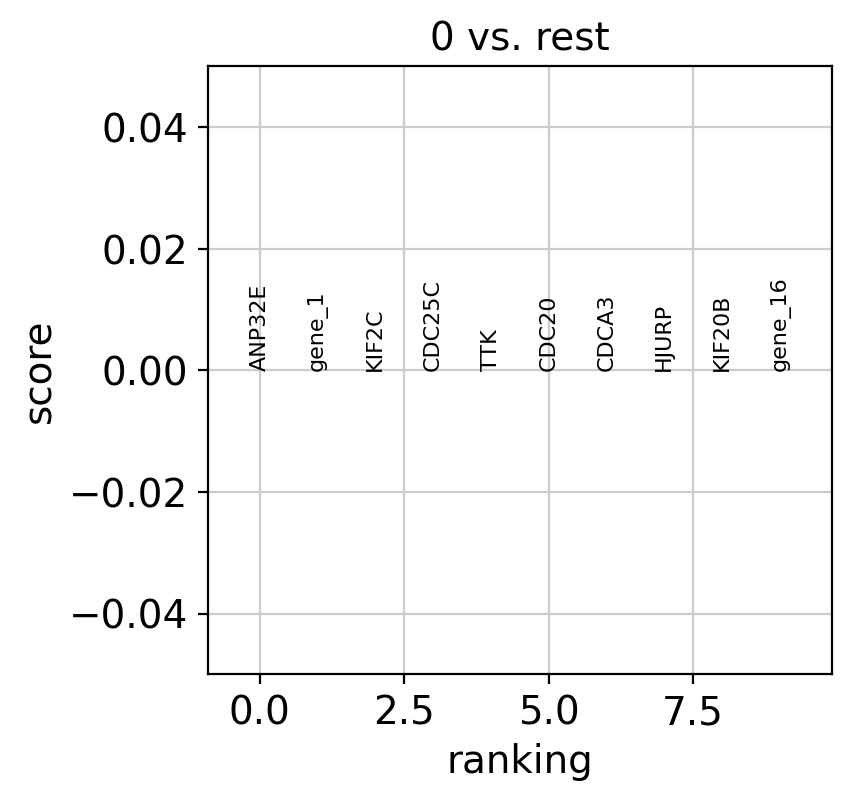

In [14]:
sc.tl.rank_genes_groups(filtered_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(filtered_adata, n_genes=10, sharey=False)